# Text Analytics


# Assignment 3

### *Submitted by:*  

**Zena Drakou | Marissa Hausman | Hitesh Prabhu | Chase Slocum | Yawen Ye - MSBA 2017 **

**Oct 3, 2016**

### Initial Setup:

1. Importing libraries
2. Reading dataset

In [1]:
from pandas import Series, DataFrame, crosstab
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re
import os

import nltk
from nltk import word_tokenize
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [2]:
df = pd.read_csv('files\scores.csv')

### Task A and B

**A:**

The sentiment scores worksheet in the data file “Assignment 3 Sentiment Scores.csv” (on Canvas) provides sentiment scores (+5 to -5) of forum users on 10 car models. Each row represents a post (not shown) that can mention multiple models. Only positive and negative sentiments are noted.


From these sentiment scores, create a directed product comparison network (and use NodeXL or, even better, write your own code in Python using networkx or R). Use the principles laid out in the article “Product comparison networks” to answer this question. 

**B:**

Calculate both unweighted and weighted PageRank scores for each car. Note that NodeXL can’t calculate weighted PageRank scores. What are the correlations between these metrics and sales figures shown below? What additional information do weighted PageRanks capture? Use a python script to calculate weighted PageRanks. Unweighted PageRanks can be calculated in NodeXL, or you can write a python script for that task as well.  

,car,weighted_pagerank_score
7,3series,0.135974
4,LS,0.111356
8,ES,0.109308
3,RX,0.105513
2,Sclass,0.103705
1,7series,0.101003
6,A8,0.098606
9,5series,0.088448
0,XJ,0.074791
5,A6,0.071297


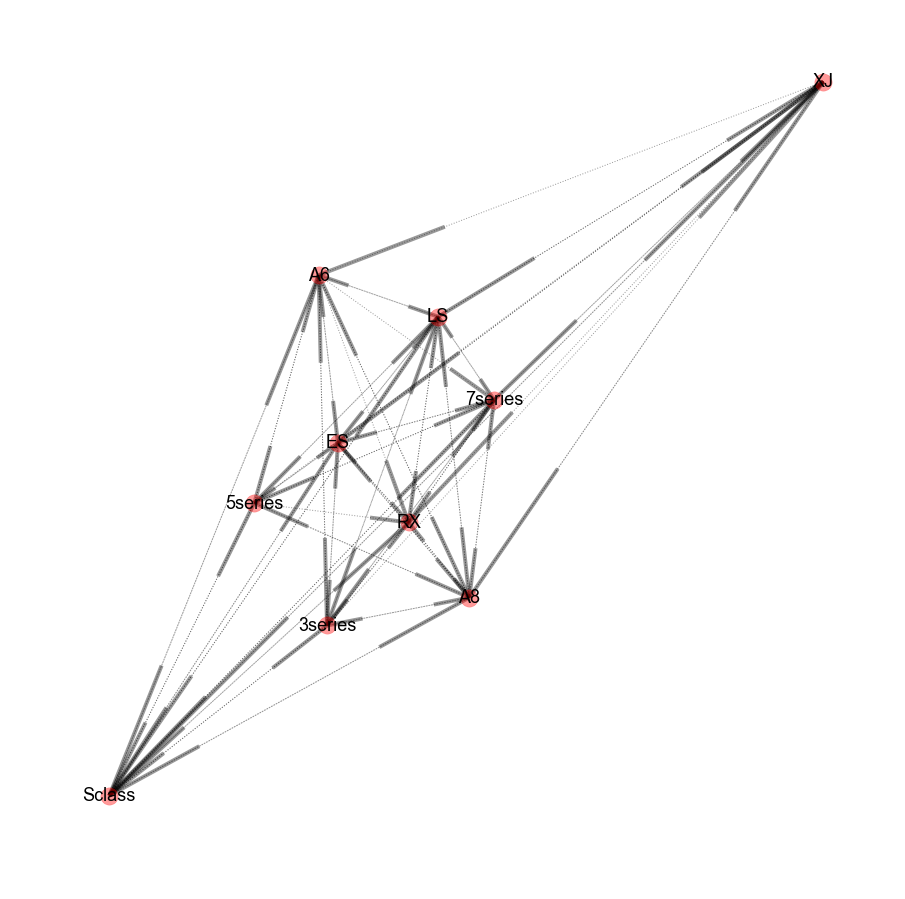

In [11]:
G = nx.DiGraph()
column = df.columns
column

G.add_nodes_from(column)
for first in range(len(column) - 1):
    for second in range(len(column) - first - 1):
        po_count = 0
        ne_count = 0
        po_sum = 0
        ne_sum = 0
        pweight = 0
        nweight = 0
        i = df[column[first]] - df[column[first + second + 1]]
        for num in i:
            if num < 0:
                ne_count = ne_count + 1
                ne_sum = ne_sum + num
            elif num > 0:
                po_count = po_count + 1
                po_sum = po_sum + num
        if ne_count > 0:
            nweight = ne_sum*1.0 / ne_count*1.0
            G.add_edge(column[first], column[first + second + 1], weight = abs(nweight)) 
        if po_count > 0:
            pweight = po_sum*1.0 / po_count*1.0
            G.add_edge(column[first + second + 1], column[first] , weight = abs(pweight))

plt.figure(figsize=(12,12)) 
nx.draw(G, with_labels=True, alpha=0.4, arrowsize=3, style='dotted', font_size=18)
pageranks = pd.DataFrame.from_dict(nx.pagerank(G, max_iter=10000), orient = 'index')
pageranks = pageranks.reset_index()
pageranks.columns = ['car','weighted_pagerank_score']
pageranks.sort_values(by = 'weighted_pagerank_score', ascending = False)

In [4]:
car_sales = pd.read_csv('files/sales.csv')
car_sales = car_sales.merge(pageranks)
car_sales

,car,sales_2012_2013,weighted_pagerank_score
0,A6,20000,0.071297
1,A8,12000,0.098606
2,3series,220000,0.135974
3,5series,60000,0.088448
4,7series,14000,0.101003
5,XJ,6600,0.074791
6,ES,135000,0.109308
7,LS,30000,0.111356
8,RX,120000,0.105513
9,Sclass,25000,0.103705


_The product BMW 3-Series is the best-selling product and does get the highest PageRank score in the network;_

_Lexus ES ranks #2 in sale and get a third highest PageRank score_

In [5]:
# Checking Spearman correlation
from scipy.stats.stats import pearsonr     
print pearsonr(car_sales['weighted_pagerank_score'], car_sales['sales_2012_2013'])
car_sales[['sales_2012_2013','weighted_pagerank_score']].corr(method='spearman', min_periods=1)

(0.73642872095740763, 0.015141721321612053)


,sales_2012_2013,weighted_pagerank_score
sales_2012_2013,1.000000,0.721212
weighted_pagerank_score,0.721212,1.000000


,car,unweighted_pagerank_score
1,Sclass,0.110645
4,LS,0.110645
6,A8,0.110645
8,ES,0.110645
2,7series,0.109464
3,RX,0.106068
7,3series,0.092526
0,XJ,0.086495
5,A6,0.085367
9,5series,0.077500


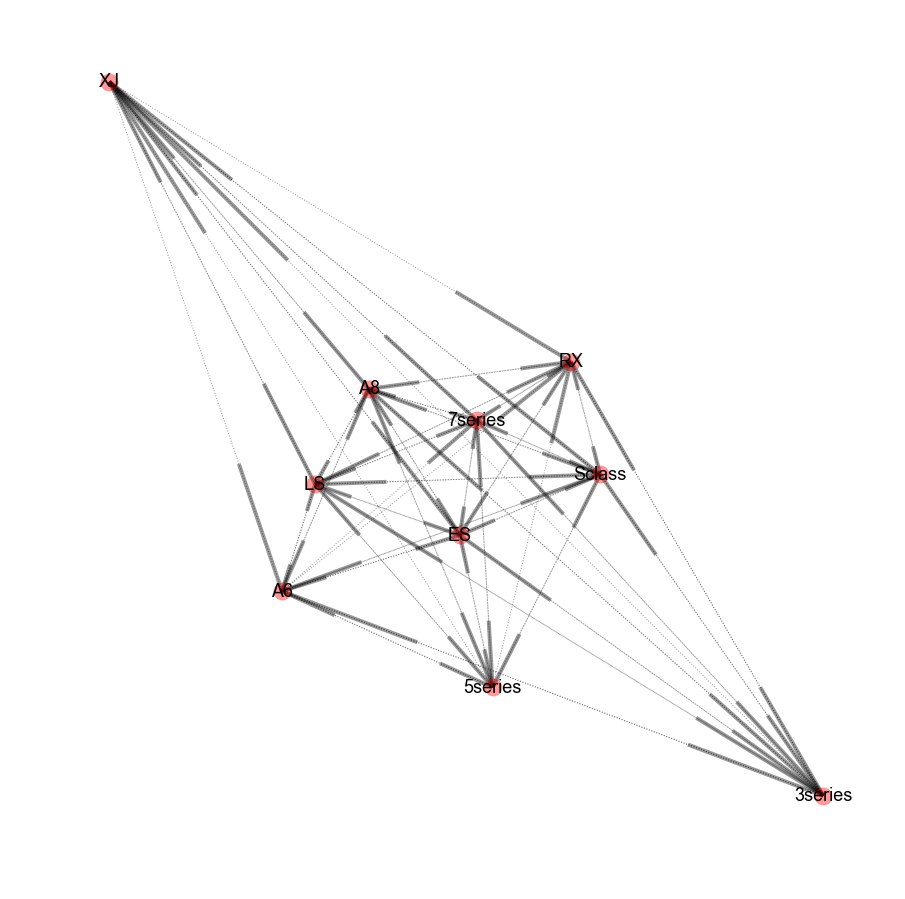

In [12]:
G2 = nx.DiGraph()
column = df.columns
column

G2.add_nodes_from(column)
for first in range(len(column) - 1):
    for second in range(len(column) - first - 1):
        po_count = 0
        ne_count = 0
        po_sum = 0
        ne_sum = 0
        i = df[column[first]] - df[column[first + second + 1]]
        for num in i:
            if num < 0:
                ne_count = ne_count + 1
                ne_sum = ne_sum + num
            elif num > 0:
                po_count = po_count + 1
                po_sum = po_sum + num
        if ne_count > 0:
            G2.add_edge(column[first], column[first + second + 1]) 
        if po_count > 0:
            G2.add_edge(column[first + second + 1], column[first])

plt.figure(figsize=(12,12)) 
nx.draw(G2, with_labels=True, alpha=0.4, arrowsize=3, style='dotted', font_size=18)
pageranks = pd.DataFrame.from_dict(nx.pagerank(G2, max_iter=10000), orient = 'index')
pageranks = pageranks.reset_index()
pageranks.columns = ['car','unweighted_pagerank_score']
pageranks.sort_values(by = 'unweighted_pagerank_score', ascending = False)

In [7]:
car_sales = car_sales.merge(pageranks)

# Checking Spearman correlation
from scipy.stats.stats import pearsonr     
print pearsonr(car_sales['unweighted_pagerank_score'], car_sales['sales_2012_2013'])
car_sales[['sales_2012_2013','unweighted_pagerank_score']].corr(method='spearman', min_periods=1)

(-0.043568997178620172, 0.90487353028121764)


,sales_2012_2013,unweighted_pagerank_score
sales_2012_2013,1.000000,0.006253
unweighted_pagerank_score,0.006253,1.000000


In [8]:
car_sales

,car,sales_2012_2013,weighted_pagerank_score,unweighted_pagerank_score
0,A6,20000,0.071297,0.085367
1,A8,12000,0.098606,0.110645
2,3series,220000,0.135974,0.092526
3,5series,60000,0.088448,0.077500
4,7series,14000,0.101003,0.109464
5,XJ,6600,0.074791,0.086495
6,ES,135000,0.109308,0.110645
7,LS,30000,0.111356,0.110645
8,RX,120000,0.105513,0.106068
9,Sclass,25000,0.103705,0.110645


_If we use unweighted pageranks as a measure of how well our model is doing, we get far worse correlations, and this rank does not distinguish the **strength** of  the positive or negative sentiment. For example, The ES, LS, RX and A8 all have the same rank._

_Thus, we believe that weighted pageranks perform much better._

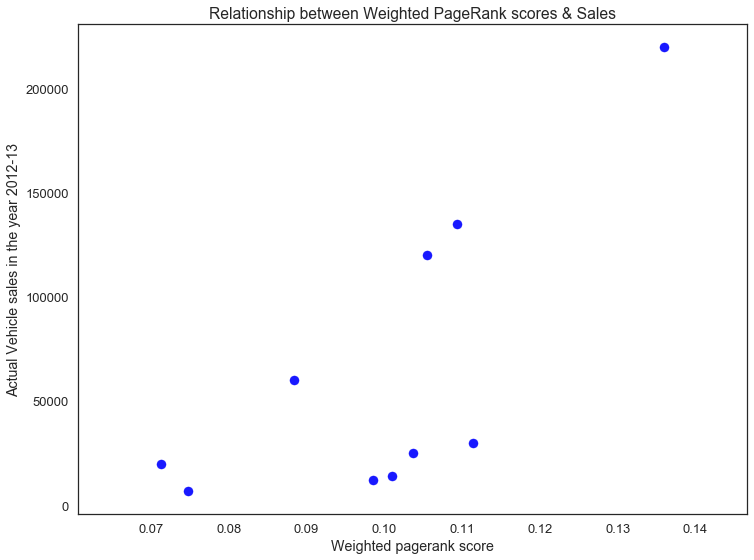

In [26]:
plt.figure(figsize=(12,9)) 
plt.scatter(car_sales['weighted_pagerank_score'], car_sales['sales_2012_2013'], 
            alpha=0.9, c='b')
plt.xlabel('Weighted pagerank score')
plt.ylabel('Actual Vehicle sales in the year 2012-13')
plt.title("Relationship between Weighted PageRank scores & Sales")

_The figure above shows the trend of actual sales with the corresponding weighted rank score. As one can observe, the figure shows a positive inclination; higher sales of a product is generally correlated with a higher page rank score._

_It is also interesting to observe that there appear to be two distinct trend lines._

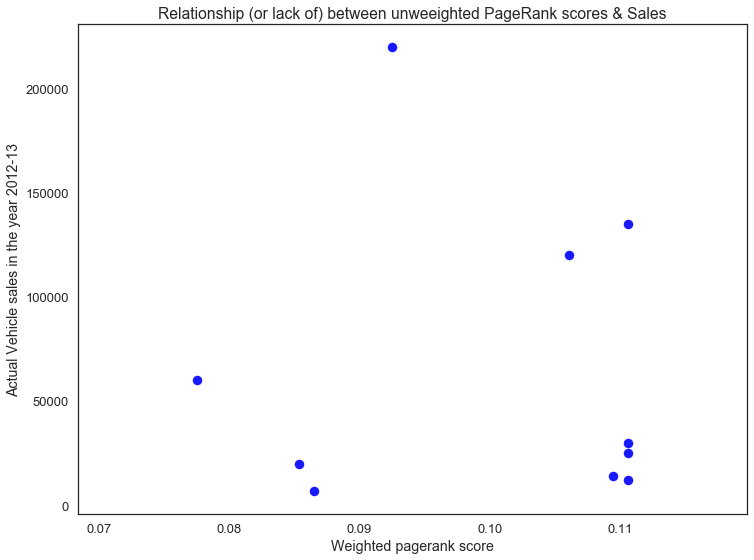

In [27]:
plt.figure(figsize=(12,9)) 
plt.scatter(car_sales['unweighted_pagerank_score'], car_sales['sales_2012_2013'], 
            alpha=0.9, c='b')
plt.xlabel('Weighted pagerank score')
plt.ylabel('Actual Vehicle sales in the year 2012-13')
plt.title("Relationship (or lack of) between unweeighted PageRank scores & Sales")

_The figure above shows the trend of actual sales with the corresponding *unweighted* rank score. This graph is less informative than the previous graph and hence we see poorer correlation between the two._

**Final verdict on the correlation between PageRanks and sales:**

_Since Pearson correlation is used, two features are required to be linearly correlated with each other. However, in our case of unweighted page rank vs Car Sales, since our P value of rejecting the "not linearly correlated" hypothesis is really large - about 90%, we fail to reject the null hypothesis and so we can not say the two datasets - cars selling vs their page rank score is linearly correlated._

### Task C

The above sentiment scores above were obtained by manually reading each post.  The file “Assignment 3 Edmunds Posts.xlsx” provide a bunch of actual messages (combine the worksheets). Your task is to automate the sentiment extraction from each post.  As in tasks A and B, focus on the same 10 models (note that other models may also be mentioned, but that they should be ignored).     


Write one or more python or R script(s) to generate sentiment scores for the 10 models just as in the sentiment scores worksheet.  This will be an unsupervised approach. One possibility (but not the only one) is to take the dictionary of SentiStrength (along with the default sentiment scores) and use it as inputs in your script(s). Your script should consider lemmatization (e.g., liking and liked must be treated as the same). 
Generate sentiment scores with your script(s), find weighted PageRank of each of the 10 cars and correlate with the sales figures above. How does the correlation of this automated approach compare with that of manual scoring in task B?


In [28]:
## read in posts
Posts=pd.read_csv('files/Posts.csv')
posts=Posts['Posts']


lemmatizer = WordNetLemmatizer()

stop_words = set(stopwords.words("english"))
stop_words.update(['.','..','...', ',', '`','"', "'",'``','""', "''", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}','****', '#', '$']) 

review = []
def tolist_utf8(h):
    review.append(h.decode('utf-8').lower())

posts.map(tolist_utf8)

post_tokenize = []

# tokenize reviews
for review in review:
    word_tokenize = nltk.word_tokenize(review)
    lemma_word = map(lambda x: lemmatizer.lemmatize(x), word_tokenize)
    cleaned_text = filter(lambda x: x not in stop_words, lemma_word)
    post_tokenize.append(cleaned_text)

In [29]:
## pull post segments related to car names
clean_posts =[]

for post in post_tokenize:
    clean_posts.append(' '.join(post))

cars={'lexuses':'ES', 'es':'ES', 'lexusrx':'RX', 'rx':'RX', 'lexusls':'LS', 'ls':'LS', 'jaguarxj':'XJ', 'xj':'XJ',
     'sclass':'SCLASS', 'a6':'A6', 'a8':'A8', '3series':'3SERIES', '5series':'5SERIES', '7series':'7SERIES'}
models=cars.values()
variations=cars.keys()

posts_updated=[]
def tolist_reg(h):
    posts_updated.append(h.encode('utf-8'))

for item in clean_posts:
    tolist_reg(item)

columns = ['post','model','words']
sentiments =[]

for index,pst in enumerate(posts_updated):
    words = pst.split()
    for num,word in enumerate(words):
        if word in variations:
            current_model=cars[word]
            last = num + 5
            first = num-4
            if first <0:
                first=0
            near_words=words[first:last]
            sentiments.append([index,current_model,near_words])
    
sentiments_df=pd.DataFrame(sentiments, columns=columns)

In [30]:
## read in sentistrength words and scores

word_sent = []
fp = open('files/EmotionLookupTable.txt', 'r')

for line in fp:  # Iterate over lines from a file
    line = line.rstrip()
    elt_raw=re.findall('\S+\t+[\-0-9][\-0-9]?', line)
    if len(elt_raw) > 0:
        word_sent.append(elt_raw[0])
fp.close()

sent_words={}

for item in word_sent:
    pair=re.findall('[^\*\t]+', item)
    sent_words[pair[0]]=pair[1]

word_scores=pd.Series(sent_words)

In [31]:
## Calculate the sentiments of each model for each review

def get_sentiment(portion):
    portion_score = 0
    for word in portion:
        if word in list(word_scores.keys()):
            portion_score += int(word_scores[word])
    return portion_score
            
sentiments_df['scores']=sentiments_df['words'].map(get_sentiment)

posts_sentiments = pd.crosstab(sentiments_df['post'], sentiments_df['model'], values=sentiments_df['scores'], aggfunc=sum)
posts_sentiments.index.name= None

,car,sentiBased_weighted_pagerank_score
2,7SERIES,0.158388
9,LS,0.134604
1,SCLASS,0.121147
7,3SERIES,0.101367
6,A8,0.093217
4,5SERIES,0.091941
8,ES,0.090483
3,RX,0.078320
5,A6,0.075579
0,XJ,0.054955


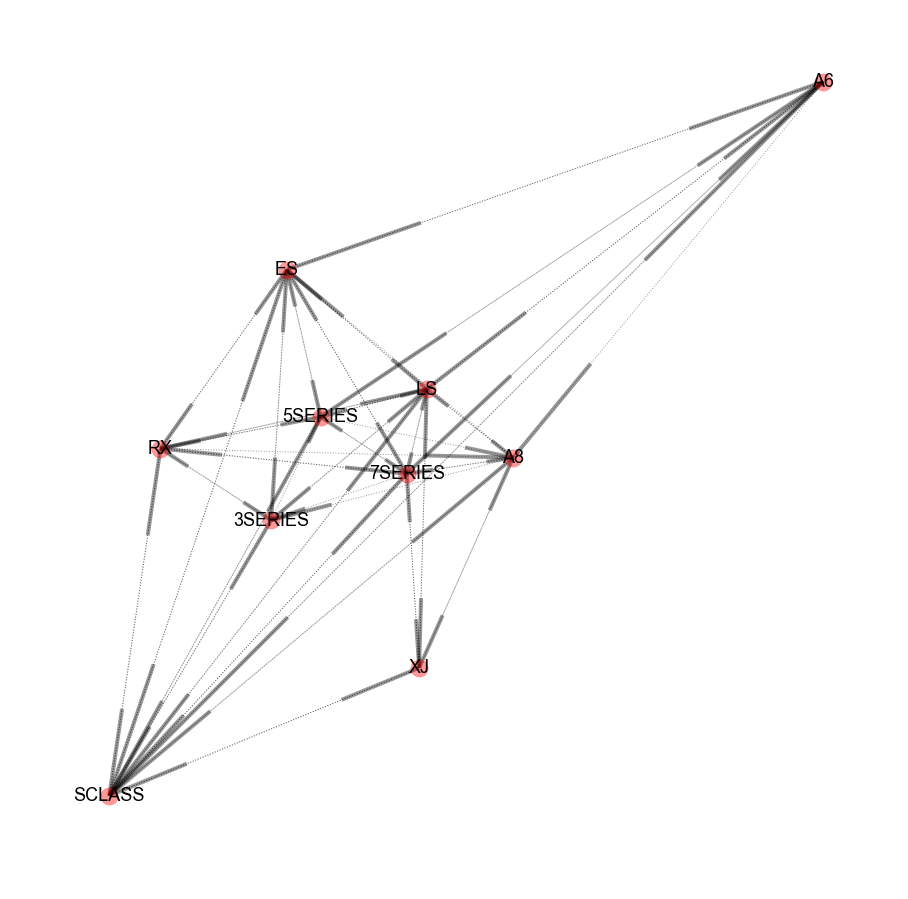

In [36]:
P = nx.DiGraph()
column_posts = posts_sentiments.columns

P.add_nodes_from(column_posts)
for first in range(len(column_posts) - 1):
    for second in range(len(column_posts) - first - 1):
        po_count = 0
        ne_count = 0
        po_sum = 0
        ne_sum = 0
        pweight = 0
        nweight = 0
        i = posts_sentiments[column_posts[first]] - posts_sentiments[column_posts[first + second + 1]]
        for num in i:
            if num < 0:
                ne_count = ne_count + 1
                ne_sum = ne_sum + num
            elif num > 0:
                po_count = po_count + 1
                po_sum = po_sum + num
        if ne_count > 0:
            nweight = ne_sum*1.0 / ne_count*1.0
            P.add_edge(column_posts[first], column_posts[first + second + 1], weight = abs(nweight)) 
        if po_count > 0:
            pweight = po_sum*1.0 / po_count*1.0
            P.add_edge(column_posts[first + second + 1], column_posts[first] , weight = abs(pweight))

plt.figure(figsize=(12,12)) 
nx.draw(P, with_labels=True, alpha=0.4, arrowsize=3, style='dotted', font_size=18)
pageranks = pd.DataFrame.from_dict(nx.pagerank(P, weight = 'weight', max_iter=10000), orient = 'index')
pageranks = pageranks.reset_index()
pageranks.columns = ['car','sentiBased_weighted_pagerank_score']
pageranks.sort_values(by = 'sentiBased_weighted_pagerank_score', ascending = False)

In [37]:
car_sales = pd.read_csv('files/sales_upper.csv')
car_sales = car_sales.merge(pageranks)
car_sales

,car,sales_2012_2013,sentiBased_weighted_pagerank_score
0,A6,20000,0.075579
1,A8,12000,0.093217
2,3SERIES,220000,0.101367
3,5SERIES,60000,0.091941
4,7SERIES,14000,0.158388
5,XJ,6600,0.054955
6,ES,135000,0.090483
7,LS,30000,0.134604
8,RX,120000,0.078320
9,SCLASS,25000,0.121147


In [38]:
# Checking Spearman correlation
car_sales[['sales_2012_2013','sentiBased_weighted_pagerank_score']].corr(method='spearman', min_periods=1)

,sales_2012_2013,sentiBased_weighted_pagerank_score
sales_2012_2013,1.000000,0.090909
sentiBased_weighted_pagerank_score,0.090909,1.000000


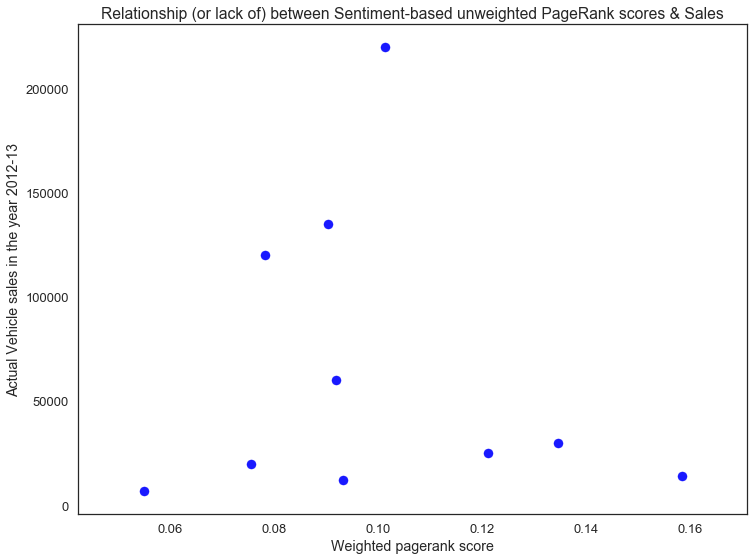

In [41]:
plt.figure(figsize=(12,9)) 
plt.scatter(car_sales['sentiBased_weighted_pagerank_score'], car_sales['sales_2012_2013'], 
            alpha=0.9, c='b')
plt.xlabel('Weighted pagerank score')
plt.ylabel('Actual Vehicle sales in the year 2012-13')
plt.title("Relationship (or lack of) between Sentiment-based unweighted PageRank scores & Sales")

_This correlation is worse than part B. However, the above graph suggests there are two different trends in our data. Individually, it appears these trends are better correlated with pagerank than they are when considered together. There is likely some additional variable at play here that, when adjusted for, would allow us to get better correlations._

_One suggestion would be to split up cars into different segments - mid-range, luxury, etc._